# Exploring Dandiset 001361: Hippocampal Population Coding During Virtual Navigation

> **Note**: This notebook was generated with AI assistance. Users should carefully validate all code and results before use in research.

## Overview
This notebook introduces DANDI:001361 ([link](https://dandiarchive.org/dandiset/001361/0.250406.0045)), which contains two-photon calcium imaging data from mouse hippocampus during virtual navigation. The data supports research on how hippocampal neurons encode sequences of events relative to reward locations.

### Dataset Features
- **Species**: Mouse (Mus musculus)
- **Brain Region**: Hippocampal CA1
- **Data Types**: Two-photon calcium imaging, behavioral tracking
- **Task**: Virtual linear track navigation with changing reward locations
- **Scope**: 11 mice, 152 NWB files (~92 GB)

### This Notebook Covers
1. Accessing NWB files via DANDI
2. Exploring behavioral data (position, rewards, trials)
3. Examining calcium imaging data and cell segmentation
4. Visualizing neural activity alongside behavior

## Required Packages

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dandi.dandiapi import DandiAPIClient

## Accessing the Dandiset
First, we'll connect to DANDI and enumerate the available NWB files:

In [2]:
# Initialize DANDI client
client = DandiAPIClient()
dandiset = client.get_dandiset('001361', '0.250406.0045')

# List all NWB files
assets = list(dandiset.get_assets_by_glob('*.nwb'))

# Create summary table
files_info = [
    {'path': a.path, 'size_MB': round(a.size / 1e6, 2)}
    for a in assets
]
files_df = pd.DataFrame(files_info)

print(f"Total NWB files: {len(files_df)}")
print(f"Total size: {files_df['size_MB'].sum() / 1000:.2f} GB\n")
print("First few files:")
print(files_df.head())

Total NWB files: 152
Total size: 92.56 GB

First few files:
                                        path  size_MB
0  sub-m11/sub-m11_ses-05_behavior+ophys.nwb    99.31
1  sub-m11/sub-m11_ses-04_behavior+ophys.nwb    89.67
2  sub-m11/sub-m11_ses-07_behavior+ophys.nwb   119.72
3  sub-m11/sub-m11_ses-06_behavior+ophys.nwb    94.61
4  sub-m11/sub-m11_ses-08_behavior+ophys.nwb   128.45


## Loading and Exploring an Example Session
We'll examine one session in detail to understand the data structure:

In [3]:
# Load a sample NWB file
asset_path = "sub-m11/sub-m11_ses-05_behavior+ophys.nwb"
asset = next(dandiset.get_assets_by_glob(asset_path))
url = asset.download_url

# Open remote NWB file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Extract key metadata
subject = nwb.subject
subject_info = {
    'subject_id': subject.subject_id,
    'species': subject.species,
    'sex': subject.sex,
    'date_of_birth': str(subject.date_of_birth.date())
}
session_info = {
    'session_id': nwb.session_id,
    'session_start_time': str(nwb.session_start_time.date()),
    'description': nwb.session_description,
    'experimenter': nwb.experimenter
}

print("Subject Information:")
for k, v in subject_info.items():
    print(f"{k}: {v}")
print("\nSession Information:")
for k, v in session_info.items():
    print(f"{k}: {v}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Subject Information:
subject_id: m11
species: Mus musculus
sex: M
date_of_birth: 2022-09-20

Session Information:
session_id: 05
session_start_time: 2023-02-25
description: processed suite2p data
experimenter: ('Mari Sosa',)


## Behavioral Data
The dataset includes rich behavioral measurements during virtual navigation. Let's visualize key behavioral signals:

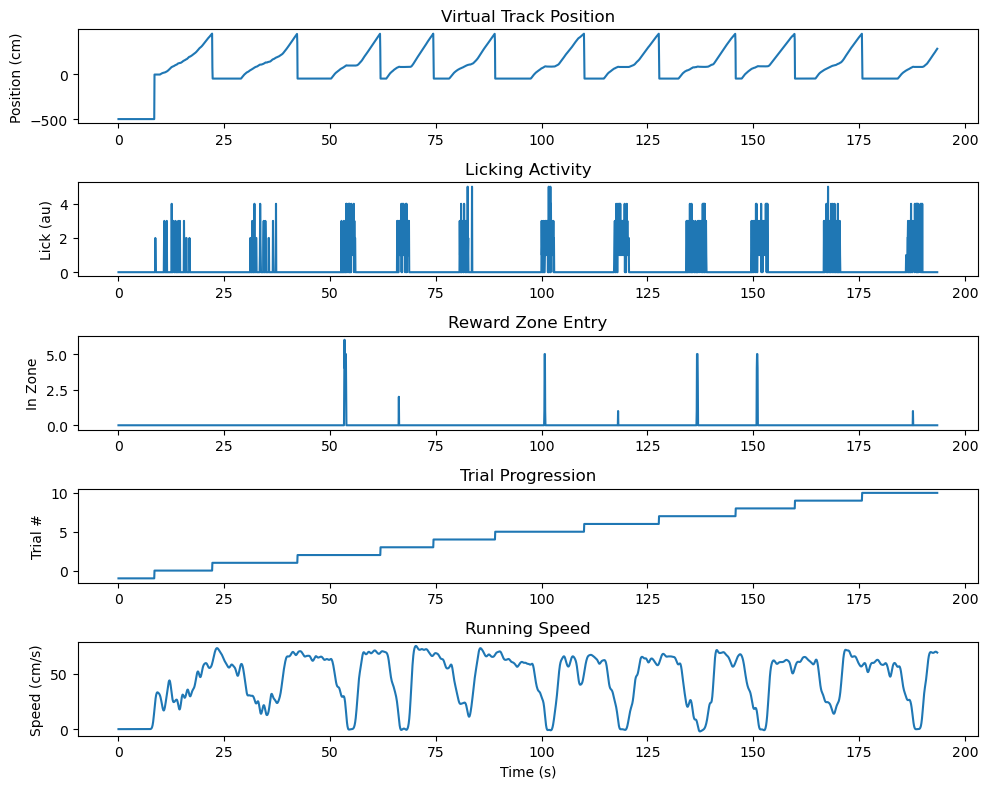

In [4]:
# Get behavioral timeseries for first 3 minutes (~3000 frames at 15.5 Hz)
N = 3000
behavior_mod = nwb.processing['behavior'].data_interfaces['BehavioralTimeSeries']
beh_signals = {}
for key in ['position', 'lick', 'reward_zone', 'trial number', 'speed']:
    ts = behavior_mod.time_series[key]
    beh_signals[key] = ts.data[:N]

time_sec = np.arange(N) / 15.5

# Plot behavioral signals
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(time_sec, beh_signals['position'])
plt.ylabel('Position (cm)')
plt.title('Virtual Track Position')

plt.subplot(512)
plt.plot(time_sec, beh_signals['lick'])
plt.ylabel('Lick (au)')
plt.title('Licking Activity')

plt.subplot(513)
plt.plot(time_sec, beh_signals['reward_zone'])
plt.ylabel('In Zone')
plt.title('Reward Zone Entry')

plt.subplot(514)
plt.plot(time_sec, beh_signals['trial number'])
plt.ylabel('Trial #')
plt.title('Trial Progression')

plt.subplot(515)
plt.plot(time_sec, beh_signals['speed'])
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Running Speed')

plt.tight_layout()
plt.show()

## Two-Photon Imaging Data
Each session contains processed calcium imaging data from Suite2p, including:
- ROI/cell segmentation
- Raw fluorescence traces
- Deconvolved activity

In [5]:
# Get imaging data dimensions
ophys_proc = nwb.processing['ophys']
flu = ophys_proc.data_interfaces['Fluorescence'].roi_response_series['plane0']
trace_shape = flu.data.shape

# Get segmentation info
seg = ophys_proc.data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
n_cells = seg.id.data.shape[0]

print(f"Calcium traces shape: {trace_shape} (frames × cells)")
print(f"Number of segmented ROIs: {n_cells}")

Calcium traces shape: (20684, 358) (frames × cells)
Number of segmented ROIs: 358


### Visualizing Neural Activity
Let's examine calcium traces from example cells alongside their deconvolved activity:

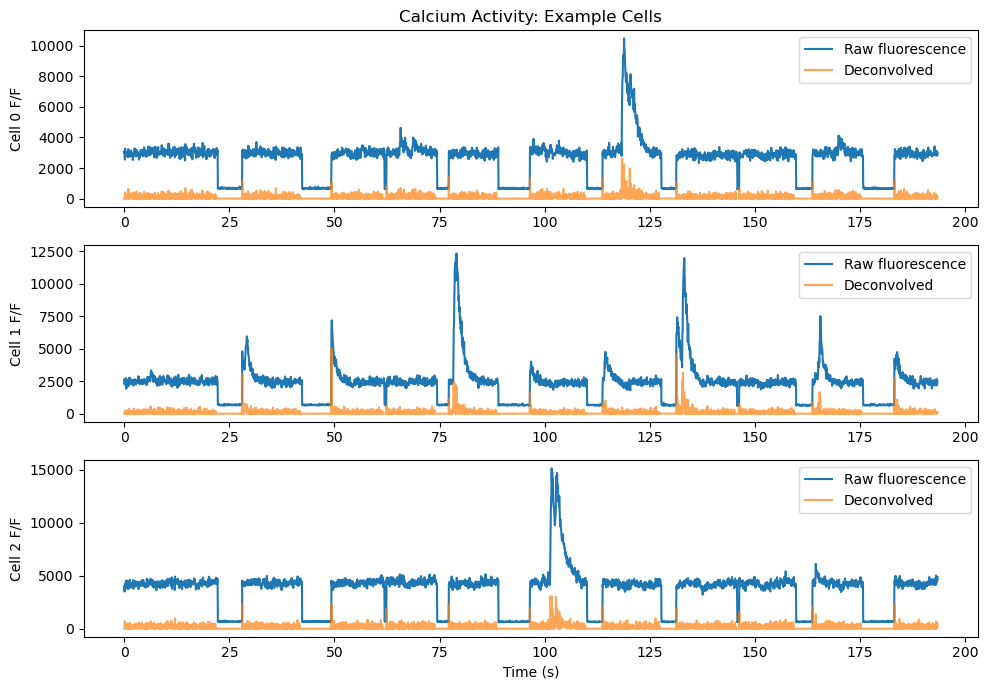

In [6]:
# Get fluorescence and deconvolved traces for first 3 putative cells
iscell = seg['iscell'].data[:, 0] == 1
cell_indices = np.where(iscell)[0][:3]
flu_traces = ophys_proc.data_interfaces['Fluorescence'].roi_response_series['plane0'].data[:, cell_indices]
dec_traces = ophys_proc.data_interfaces['Deconvolved'].roi_response_series['plane0'].data[:, cell_indices]

# Plot individual cell traces
plt.figure(figsize=(10, 7))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(time_sec, flu_traces[:N, i], label='Raw fluorescence')
    plt.plot(time_sec, dec_traces[:N, i], label='Deconvolved', alpha=0.7)
    plt.ylabel(f'Cell {cell_indices[i]} F/F')
    plt.legend(loc='upper right')
    if i == 0:
        plt.title('Calcium Activity: Example Cells')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

## Summary and Next Steps
This notebook demonstrated how to:
1. Access NWB files from DANDI:001361
2. Extract behavioral and imaging metadata
3. Visualize behavioral variables during virtual navigation
4. Access and plot calcium imaging traces

### Potential Analyses
- Align neural activity to behavioral events (rewards, trial starts)
- Map place fields using position and calcium data
- Study population dynamics during learning
- Compare activity across different reward locations

### Additional Resources
- [Paper's analysis code](https://github.com/GiocomoLab/Sosa_et_al_2024)
- [Interactive NWB browser](https://neurosift.app/nwb?dandisetId=001361&dandisetVersion=0.250406.0045)